In [59]:
import numpy as np
import pandas as pd
import sklearn
import re
import seaborn as sns
try:
    import xgboost 
    from xgboost import XGBClassifier
except ImportError:
    print("Please install xgboost, refer to https://xgboost.readthedocs.io/en/latest/build.html")
try:
    import featexp
except ImportError:
    print("Please install featexp by pip.")
import matplotlib.pyplot as plt

import time
from datetime import datetime
now = datetime.now().strftime('%Y%m%d%H%M%S')
print("Now is {}".format(now))

import warnings
warnings.filterwarnings(action ='ignore')
from hyperopt import hp, fmin, tpe
from sklearn.metrics import accuracy_score
from functools import partial
from sklearn.ensemble import RandomForestClassifier
# import subprocess
# print(subprocess.check_output(['conda','env', 'list']))

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

# TODO: run pip or self package

Please install featexp by pip.
Now is 20181123222024


In [2]:
from jinja2 import Environment, ChoiceLoader, FileSystemLoader
from IPython.display import HTML, display
from pandas.io.formats.style import Styler

%mkdir templates

A subdirectory or file templates already exists.


In [3]:
%%file templates/myhtml.tpl
{% extends "html.tpl" %}
{% block table %}
<h1>{{ table_title|default("My Table") }}</h1>
{{ super() }}
{% endblock table %}

Overwriting templates/myhtml.tpl


In [4]:
class MyStyler(Styler):
    env = Environment(
        loader=ChoiceLoader([
            FileSystemLoader("templates"),  # contains ours
            Styler.loader,  # the default
        ])
    )
    template = env.get_template("myhtml.tpl")

In [5]:
def color_05_red(val):
    color = 'red' if val < 0.5 else 'black'
    return 'color: %s' % color

In [6]:
train_df = pd.read_csv('all//train.csv')
test_df = pd.read_csv('all//test.csv')

In [7]:
train_df.info()
test_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Baseline 

In [8]:
def baseline(features, train_df, test_df, Target="Survived"):
    
    features.append(Target)
    data1 = train_df.copy()[features]
    features.pop()
    Target = [Target]
        #Machine Learning Algorithm (MLA) Selection and Initialization
    MLA = [
        #Ensemble Methods
        ensemble.AdaBoostClassifier(),
        ensemble.BaggingClassifier(),
        ensemble.ExtraTreesClassifier(),
        ensemble.GradientBoostingClassifier(),
        ensemble.RandomForestClassifier(),

        #Gaussian Processes
        gaussian_process.GaussianProcessClassifier(),

        #GLM
        linear_model.LogisticRegressionCV(),
        linear_model.PassiveAggressiveClassifier(),
        linear_model.RidgeClassifierCV(),
        linear_model.SGDClassifier(),
        linear_model.Perceptron(),

        #Navies Bayes
        naive_bayes.BernoulliNB(),
        naive_bayes.GaussianNB(),

        #Nearest Neighbor
        neighbors.KNeighborsClassifier(),

        #SVM
        svm.SVC(probability=True),
        svm.NuSVC(probability=True),
        svm.LinearSVC(),

        #Trees    
        tree.DecisionTreeClassifier(),
        tree.ExtraTreeClassifier(),

        #Discriminant Analysis
        discriminant_analysis.LinearDiscriminantAnalysis(),
        discriminant_analysis.QuadraticDiscriminantAnalysis(),


        #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
        XGBClassifier()    
        ]



    #split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
    #note: this is an alternative to train_test_split
    cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

    #create table to compare MLA metrics
    MLA_columns = ['MLA Name', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Time','MLA Parameters',]
    MLA_compare = pd.DataFrame(columns = MLA_columns)

    #create table to compare MLA predictions
    MLA_predict = data1[Target]

    #index through MLA and save performance to table
    row_index = 0
    for alg in MLA:

        #set name and parameters
        MLA_name = alg.__class__.__name__
        MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
        MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

        #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
        cv_results = model_selection.cross_validate(alg, data1[features].values, data1[Target].values.ravel(), cv  = cv_split)

        MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
        MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
        MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   


        #save MLA predictions - see section 6 for usage
        alg.fit(data1[features], data1[Target])
        MLA_predict[MLA_name] = alg.predict(data1[features])

        row_index+=1


    #display and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
    MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
    display(HTML(MyStyler(MLA_compare).render(table_title="Model Cross Validation Accuracies with feature {}".format('+'.join(features)))))
#     return MLA_compare
    
def submit(train_prediction, test_prediction, label, features, train_df, test_df):
    
    submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": test_prediction
    })
    submission.to_csv('titanic_baseline_{}_with_{}.csv'.format(label, '+'.join(features)), index=False)
    
    print('Exported')   


# Encoding

In [9]:
train_df.loc[train_df['Sex']=='male', 'Sex']=1
train_df.loc[train_df['Sex']=='female', 'Sex']=0
test_df.loc[test_df['Sex']=='male', 'Sex']=1
test_df.loc[test_df['Sex']=='female', 'Sex']=0

train_df.loc[train_df['Embarked']=='S', 'Embarked']=0
train_df.loc[train_df['Embarked']=='C', 'Embarked']=1
train_df.loc[train_df['Embarked']=='Q', 'Embarked']=2

test_df.loc[test_df['Embarked']=='S', 'Embarked']=0
test_df.loc[test_df['Embarked']=='C', 'Embarked']=1
test_df.loc[test_df['Embarked']=='Q', 'Embarked']=2

# Data Cleaning

In [10]:
# Check for missing data & list them 
nas = pd.concat([train_df.isnull().sum(), test_df.isnull().sum()], axis=1, keys=['Train Dataset', 'Test Dataset']) 
print('Nan in the data sets')
print(nas[nas.sum(axis=1) > 0])

Nan in the data sets
          Train Dataset  Test Dataset
Age                 177          86.0
Cabin               687         327.0
Embarked              2           0.0
Fare                  0           1.0


In [11]:
# Missing values

train_df['Age']=train_df['Age'].fillna(train_df.loc[train_df['Age'].notnull()]['Age'].mean())
train_df['Cabin'] = train_df['Cabin'].fillna(train_df['Cabin'].value_counts().index[0])
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].value_counts().index[0])

test_df['Age']=test_df['Age'].fillna(test_df.loc[train_df['Age'].notnull()]['Age'].mean())
test_df['Cabin'] = test_df['Cabin'].fillna(test_df['Cabin'].value_counts().index[0])
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].value_counts().index[0])
test_df['Fare']=test_df['Fare'].fillna(test_df.loc[train_df['Fare'].notnull()]['Fare'].mean())

# Scale numbers
train_df['Fare'] = (train_df['Fare']-train_df['Fare'].min())/(train_df['Fare'].max()-train_df['Fare'].min())
test_df['Fare'] = (test_df['Fare']-test_df['Fare'].min())/(test_df['Fare'].max()-test_df['Fare'].min())
# Assure no missing values
nas = pd.concat([train_df.isnull().sum(), test_df.isnull().sum()], axis=1, keys=['Train Dataset', 'Test Dataset']) 
if nas[nas.sum(axis=1) > 0].empty:
    print("No missing values.")
else:        
    print('Nan in the data sets')
    print(nas[nas.sum(axis=1) > 0])

No missing values.


# EDA & Feature Generation

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null int64
dtypes: float64(2), int64(7), object(3)
memory usage: 83.6+ KB


## Correlation

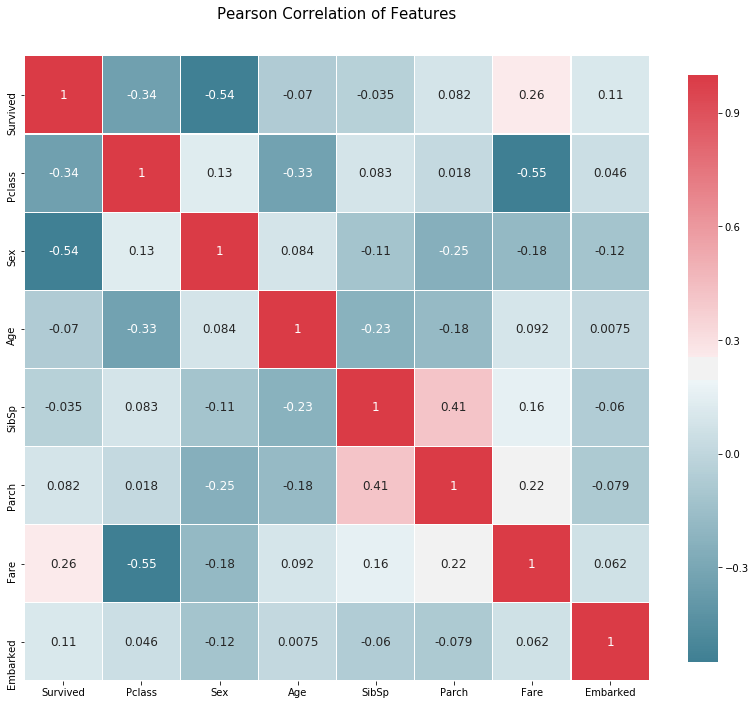

In [13]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(train_df.copy().drop(["PassengerId"], axis=1))

## Strong correlated features

In [14]:
baseline(['Sex', 'Pclass'], train_df, test_df)

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
0,AdaBoostClassifier,0.78839,0.78806,0.0737028,"{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}"
8,RidgeClassifierCV,0.78839,0.78806,0.00139625,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': None, 'cv': None, 'fit_intercept': True, 'normalize': False, 'scoring': None}"
20,QuadraticDiscriminantAnalysis,0.78839,0.78806,0.000398993,"{'priors': None, 'reg_param': 0.0, 'store_covariance': False, 'store_covariances': None, 'tol': 0.0001}"
19,LinearDiscriminantAnalysis,0.78839,0.78806,0.000797892,"{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}"
16,LinearSVC,0.78839,0.78806,0.00738029,"{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}"
12,GaussianNB,0.78839,0.78806,0.000698113,{'priors': None}
11,BernoulliNB,0.78839,0.78806,0.000798011,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}"
1,BaggingClassifier,0.792884,0.783955,0.0130652,"{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
4,RandomForestClassifier,0.792884,0.783955,0.0146608,"{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
6,LogisticRegressionCV,0.793633,0.783209,0.047473,"{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}"


## Plots with featexp

In [19]:
try:
    nums = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked']
    for feature in nums:
        featexp.get_univariate_plots(data=train_df.loc[train_df[feature].notnull()], target_col='Survived',
                              features_list=[feature], bins=10)
    featexp.get_univariate_plots(data=train_df.loc[train_df['Age'].notnull()], target_col='Survived',
                          features_list=['Age'], bins=10)
except NameError as e:
    print("Check intallation of featexp")
    print(str(e))

Check intallation of FeatExp
name 'featexp' is not defined


## Age Tranche/ Raw Age

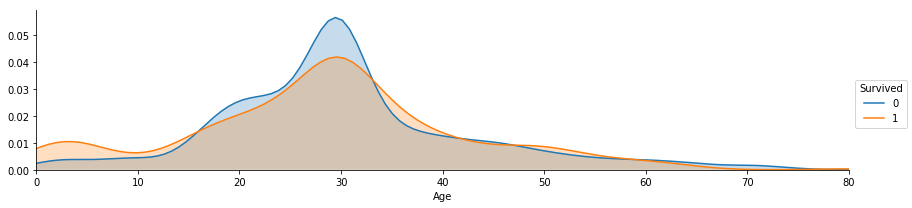

In [20]:
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid(train_df, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , train_df['Age'].max()))
a.add_legend()

In [21]:
## Generate tranch of ages
age_df = train_df.copy()
age_test_df = test_df.copy()

age_df.loc[train_df["Age"]<14, "Age"] = 1
age_df.loc[train_df["Age"]>=14, "Age"] = 2
# age_df.loc[train_df["Age"]<31, "Age"] = 3
# age_df.loc[train_df["Age"]<41, "Age"] = 4
# age_df.loc[train_df["Age"]>=41, "Age"] = 4

# age_test_df.loc[test_df["Age"]<14, "Age"] = 1
# age_test_df.loc[test_df["Age"]<25, "Age"] = 2
# age_test_df.loc[test_df["Age"]<31, "Age"] = 3
# age_test_df.loc[test_df["Age"]<41, "Age"] = 4
# age_test_df.loc[test_df["Age"]>=41, "Age"] = 4

baseline(['Age'], age_df, age_test_df)
baseline(['Sex', 'Age', 'Pclass'], age_df, age_test_df)

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
0,AdaBoostClassifier,0.631648,0.623881,0.0726057,"{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}"
1,BaggingClassifier,0.631648,0.623881,0.0129644,"{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
20,QuadraticDiscriminantAnalysis,0.631648,0.623881,0.000498581,"{'priors': None, 'reg_param': 0.0, 'store_covariance': False, 'store_covariances': None, 'tol': 0.0001}"
19,LinearDiscriminantAnalysis,0.631648,0.623881,0.000698042,"{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}"
18,ExtraTreeClassifier,0.631648,0.623881,0.000299144,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}"
17,DecisionTreeClassifier,0.631648,0.623881,0.000299168,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}"
16,LinearSVC,0.631648,0.623881,0.00329123,"{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}"
14,SVC,0.631648,0.623881,0.0202458,"{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
12,GaussianNB,0.631648,0.623881,0.000498724,{'priors': None}
21,XGBClassifier,0.631648,0.623881,0.00847707,"{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}"


,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
3,GradientBoostingClassifier,0.808614,0.795896,0.0598399,"{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}"
5,GaussianProcessClassifier,0.806367,0.794776,0.142619,"{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': 1, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}"
1,BaggingClassifier,0.808052,0.794403,0.0135638,"{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
2,ExtraTreesClassifier,0.808614,0.794403,0.0140625,"{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
18,ExtraTreeClassifier,0.808614,0.794403,0.000299191,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}"
17,DecisionTreeClassifier,0.808614,0.794403,0.000299335,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}"
21,XGBClassifier,0.807678,0.792537,0.016057,"{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}"
4,RandomForestClassifier,0.807865,0.791418,0.0146608,"{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
19,LinearDiscriminantAnalysis,0.795131,0.790672,0.000897717,"{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}"
0,AdaBoostClassifier,0.795131,0.790672,0.0729051,"{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}"


## Social Status 

In [22]:
get_title = lambda x: re.findall(r",\s(.+?)\.", x)[0]
train_df['Name'] = train_df['Name'].apply(get_title)
test_df['Name'] = test_df['Name'].apply(get_title)
print(train_df['Name'].value_counts())
print(test_df['Name'].value_counts())

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Don               1
Mme               1
the Countess      1
Jonkheer          1
Lady              1
Capt              1
Sir               1
Ms                1
Name: Name, dtype: int64
Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Dr          1
Ms          1
Name: Name, dtype: int64


### Differences between social status

In [23]:
titles = train_df['Name'].unique()
Title_Survived_Rate = pd.DataFrame(columns=titles)

for title in titles:
    Title_Survived_Rate.loc['Survived Rate', title] = train_df.loc[(train_df['Name']==title) & (train_df['Survived']==1)].shape[0] / train_df.loc[train_df['Name']==title].shape[0] 
    Title_Survived_Rate.loc['% of Persons', title] = train_df.loc[train_df['Name']==title].shape[0] / train_df.shape[0]
    
s = Title_Survived_Rate.copy().style.applymap(color_05_red, subset=pd.IndexSlice[['Survived Rate'], titles])

s.format('{:.1%}')

,Mr,Mrs,Miss,Master,Don,Rev,Dr,Mme,Ms,Major,Lady,Sir,Mlle,Col,Capt,the Countess,Jonkheer
Survived Rate,15.7%,79.2%,69.8%,57.5%,0.0%,0.0%,42.9%,100.0%,100.0%,50.0%,100.0%,100.0%,100.0%,50.0%,0.0%,100.0%,0.0%
% of Persons,58.0%,14.0%,20.4%,4.5%,0.1%,0.7%,0.8%,0.1%,0.1%,0.2%,0.1%,0.1%,0.2%,0.2%,0.1%,0.1%,0.1%


In [24]:
Title_Survived_Rate = Title_Survived_Rate.T

In [25]:
high_risk = list(Title_Survived_Rate.loc[Title_Survived_Rate['Survived Rate']<=0.3].copy().T)
medium_risk = list(Title_Survived_Rate.loc[(Title_Survived_Rate['Survived Rate']>0.3) & (Title_Survived_Rate['Survived Rate']<0.6)].copy().T)
low_risk =  list(Title_Survived_Rate.loc[Title_Survived_Rate['Survived Rate']>0.6].copy().T)    

d1 = {x: 2 for x in high_risk}
d2 = {x: 1 for x in medium_risk}
d3 = {x: 0 for x in low_risk}

d = {**d1, **d2, **d3}
print(d)

# Do not run this line two times in one session due to map
train_df['Name'] = train_df['Name'].map(d)
train_df.head()

{'Mr': 2, 'Don': 2, 'Rev': 2, 'Capt': 2, 'Jonkheer': 2, 'Master': 1, 'Dr': 1, 'Major': 1, 'Col': 1, 'Mrs': 0, 'Miss': 0, 'Mme': 0, 'Ms': 0, 'Lady': 0, 'Sir': 0, 'Mlle': 0, 'the Countess': 0}


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,2,1,22.0,1,0,A/5 21171,0.014151,C23 C25 C27,0
1,2,1,1,0,0,38.0,1,0,PC 17599,0.139136,C85,1
2,3,1,3,0,0,26.0,0,0,STON/O2. 3101282,0.015469,C23 C25 C27,0
3,4,1,1,0,0,35.0,1,0,113803,0.103644,C123,0
4,5,0,3,2,1,35.0,0,0,373450,0.015713,C23 C25 C27,0


In [45]:
test_map = {'Mr': 2, "Mrs": 0, "Miss": 0, "Master": 1, "Col":2, "Rev": 2, "Dr": 1, "Dona": 1, 'Ms': 0}
test_df['Name'] = test_df["Name"].map(test_map)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,2.0,1,34.5,0,0,330911,0.015282,B57 B59 B63 B66,2
1,893,3,0.0,0,47.0,1,0,363272,0.013663,B57 B59 B63 B66,0
2,894,2,2.0,1,62.0,0,0,240276,0.018909,B57 B59 B63 B66,2
3,895,3,2.0,1,27.0,0,0,315154,0.016908,B57 B59 B63 B66,0
4,896,3,0.0,0,22.0,1,1,3101298,0.023984,B57 B59 B63 B66,0


In [26]:
baseline(['Name'], train_df, test_df)
baseline(['Sex', 'Pclass', 'Age', 'Name'], train_df, test_df)

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
11,BernoulliNB,0.788202,0.78806,0.000498652,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}"
12,GaussianNB,0.788202,0.78806,0.000598407,{'priors': None}
20,QuadraticDiscriminantAnalysis,0.788202,0.78806,0.000398993,"{'priors': None, 'reg_param': 0.0, 'store_covariance': False, 'store_covariances': None, 'tol': 0.0001}"
19,LinearDiscriminantAnalysis,0.788202,0.78806,0.000797963,"{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}"
16,LinearSVC,0.788202,0.78806,0.00339079,"{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}"
6,LogisticRegressionCV,0.788202,0.78806,0.0374,"{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}"
8,RidgeClassifierCV,0.788202,0.78806,0.00169547,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': None, 'cv': None, 'fit_intercept': True, 'normalize': False, 'scoring': None}"
15,NuSVC,0.796629,0.785075,0.0202457,"{'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'nu': 0.5, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
14,SVC,0.796629,0.785075,0.0155581,"{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
0,AdaBoostClassifier,0.796629,0.785075,0.0731046,"{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}"


,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
3,GradientBoostingClassifier,0.868727,0.804478,0.0608372,"{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}"
21,XGBClassifier,0.850936,0.804104,0.0181515,"{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}"
6,LogisticRegressionCV,0.806367,0.799254,0.118683,"{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}"
0,AdaBoostClassifier,0.822659,0.798507,0.0746003,"{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}"
14,SVC,0.845318,0.795522,0.0409904,"{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
5,GaussianProcessClassifier,0.862734,0.795522,0.141821,"{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': 1, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}"
8,RidgeClassifierCV,0.801498,0.794403,0.00119684,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': None, 'cv': None, 'fit_intercept': True, 'normalize': False, 'scoring': None}"
15,NuSVC,0.838951,0.794403,0.0475726,"{'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'nu': 0.5, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
18,ExtraTreeClassifier,0.894569,0.79291,0.000498652,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}"
4,RandomForestClassifier,0.884644,0.792164,0.0159572,"{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"


## Embarked

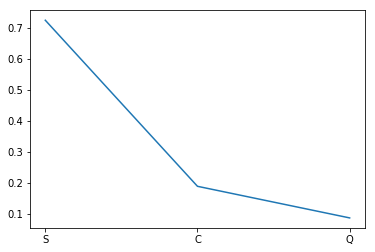

In [27]:
plt.figure()
Embarked_Survived_Rate = [train_df.loc[train_df['Embarked']==i].shape[0]/train_df.shape[0] for i in range(3)]
plt.plot(['S', 'C', 'Q'], Embarked_Survived_Rate)

In [28]:
baseline(['Embarked'], train_df, test_df)
baseline(['Sex', 'Pclass', 'Name', "Embarked"], train_df, test_df)

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
0,AdaBoostClassifier,0.635581,0.627239,0.0726056,"{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}"
1,BaggingClassifier,0.635581,0.627239,0.0129653,"{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
18,ExtraTreeClassifier,0.635581,0.627239,0.000299311,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}"
17,DecisionTreeClassifier,0.635581,0.627239,0.000299406,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}"
14,SVC,0.635581,0.627239,0.0257312,"{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
21,XGBClassifier,0.635581,0.627239,0.0102723,"{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}"
5,GaussianProcessClassifier,0.635581,0.627239,0.116688,"{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': 1, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}"
4,RandomForestClassifier,0.635581,0.627239,0.0146608,"{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
3,GradientBoostingClassifier,0.635581,0.627239,0.0364027,"{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}"
2,ExtraTreesClassifier,0.635581,0.627239,0.013464,"{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"


,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
21,XGBClassifier,0.829588,0.824627,0.0178519,"{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}"
5,GaussianProcessClassifier,0.827903,0.824627,0.154886,"{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': 1, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}"
3,GradientBoostingClassifier,0.830337,0.823507,0.0631311,"{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}"
14,SVC,0.827903,0.823507,0.0219412,"{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
2,ExtraTreesClassifier,0.830712,0.823134,0.013863,"{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
18,ExtraTreeClassifier,0.830712,0.822388,0.000398993,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}"
1,BaggingClassifier,0.830524,0.822015,0.0132643,"{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
4,RandomForestClassifier,0.830524,0.822015,0.015359,"{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
17,DecisionTreeClassifier,0.830712,0.820896,0.000498629,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}"
19,LinearDiscriminantAnalysis,0.799625,0.793284,0.000897527,"{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}"


## Plots

In [29]:
print(train_df.loc[(train_df['Age']<14) & (train_df['Sex']==1) & (train_df['Survived']==1)].shape[0] / train_df.loc[(train_df['Age']<14) & (train_df['Sex']==1)].shape[0])
train_df.loc[(train_df['Age']<14) & (train_df['Sex']==0) & (train_df['Survived']==1)].shape[0] / train_df.loc[(train_df['Age']<14) & (train_df['Sex']==0)].shape[0]

0.5675675675675675


0.6176470588235294

# Tuning parameters

In [32]:
features = ['Pclass', 'Sex', 'Age', 'Embarked', 'Name']

In [38]:

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())

]


#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, train_df[features], train_df["Survived"], cv  = cv_split)
vote_hard.fit(train_df[features], train_df["Survived"])

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, train_df[features], train_df["Survived"], cv  = cv_split)
vote_soft.fit(train_df[features], train_df["Survived"])

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)


#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       
    
            [{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
            [{    
            #GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, #default: 100
            'random_state': grid_seed
            }],
        
    
            [{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
             }],
            
    
            [{
            #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
            'alpha': grid_ratio, #default: 1.0
             }],
    
    
            #GaussianNB - 
            [{}],
    
            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]



start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(clf[1]) #vote_est is a list of tuples, index 0 is the name and index 1 is the algorithm
    #print(param)
    
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(train_df[features], train_df["Survived"])
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

Hard Voting Training w/bin score mean: 87.62
Hard Voting Test w/bin score mean: 81.94
Hard Voting Test w/bin score 3*std: +/- 7.71
----------
Soft Voting Training w/bin score mean: 87.60
Soft Voting Test w/bin score mean: 81.31
Soft Voting Test w/bin score 3*std: +/- 6.93
----------
The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 0} with a runtime of 40.93 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.1, 'n_estimators': 300, 'random_state': 0} with a runtime of 37.96 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 10, 'random_state': 0} with a runtime of 89.11 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 46.57 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 10, '

# Submission

In [41]:
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, train_df[features], train_df["Survived"], cv  = cv_split)
grid_hard.fit(train_df[features], train_df["Survived"])

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, train_df[features], train_df["Survived"], cv  = cv_split)
grid_soft.fit(train_df[features], train_df["Survived"])

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 85.11
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 81.64
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 7.42
----------
Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 83.93
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 80.90
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 5.52
----------


In [57]:
#check data for modeling
print(test_df.info())
print("-"*10)

method = "hard"
# test_df = test_df.fillna(0)
nas = test_df.isnull().sum() 
print(nas)

if method == "hard":
    test_df['Survived'] = grid_hard.predict(test_df[features])
elif method == "soft":
    test_df['Survived'] = grid_soft.predict(test_df[features])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null float64
Sex            418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          418 non-null object
Embarked       418 non-null int64
Survived       418 non-null int64
dtypes: float64(3), int64(7), object(2)
memory usage: 39.3+ KB
None
----------
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Survived       0
dtype: int64


In [61]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": test_df['Survived']
    })

file = 'titanic_preditedby{}_{}.csv'.format(method, now)
submission.to_csv(file, index=False)
print('Exported '+file)

Exportedtitanic_preditedbyhard_20181123222024.csv


In [63]:
!kaggle competitions submit -c titanic -f {file} -m "Message"

Successfully submitted to Titanic: Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:02<00:00, 1.20kB/s]
